In [ ]:
import pandas as pd
train_dir='/content/train'
test_dir='/content/test'

In [ ]:
rm -rf `find -type d -name .ipynb_checkpoints`  #TO REMOVE.IPYNB CHECKPOINTS


In [ ]:
import os
classes_train=os.listdir(train_dir)
classes_test=os.listdir(test_dir)

In [ ]:
print(classes_train)

['PNEUMONIA', 'NORMAL']


In [ ]:
print(classes_test)

['PNEUMONIA', 'NORMAL']


7. Data Augmentation

We need to know what is the data augmentation Datat augmentation means generate new data from exisiting data. We do this because the performance of deep learning neural networks often improves with the amount of data available. In this example the data was small so we use this

In [ ]:
# First for Training data
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(
    zoom_range=0.2, #the amount of zooming u need
    horizontal_flip=True, # Make a horizontal copy of image
    rescale=1.0/255.0, # Normalize the new images
    width_shift_range=0.10, # The percentage of Width shifitning
    height_shift_range=0.10, # The percentage of height shifitning
    shear_range=0.1 #Shear angle in counter-clockwise direction in degrees
)
train_generator=train_datagen.flow_from_directory(
    train_dir,
    class_mode='binary',
    color_mode='rgb',
    batch_size=32,
    target_size=(1000,1000,3)[:2]
)

Found 147 images belonging to 2 classes.


In [ ]:
# Second for Testing data
test_datagen=ImageDataGenerator(
    rescale=1.0/255.0
)
test_generator=test_datagen.flow_from_directory(
    test_dir,
    class_mode='binary',
    color_mode='rgb',
    batch_size=32,
    target_size=(1000,1000,3)[:2]
)

Found 40 images belonging to 2 classes.


Callbacks

Callbacks is a method we use it to reduce over fiting and to save time. We will use EarlyStopping to stop the training process if the accuracy dose not improved for 5 times. ReduceLROnPlateau to minimize learning rate if the accuracy dose not improved for 2 times

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
earlystop=EarlyStopping(patience=6)
learning_rate_reduction=ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.001
)

Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,Dropout,Activation,BatchNormalization
label_dict = {
    0: 'NORMAL',
    1: 'PNEUMONIA'

}
import os
import random
import numpy as np
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Define the path to the parent directory containing the subdirectories of test images
test_dir = '/content/test'

# Get a list of all the subdirectories (i.e., classes) in the test directory
subdirs = [os.path.join(test_dir, subdir) for subdir in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, subdir))]

# Randomly select a subdirectory from the test set
random_subdir = random.choice(subdirs)

# Get a list of all the image file names in the randomly selected subdirectory
image_files = os.listdir(random_subdir)

# Randomly select an image from the subdirectory
random_image_file = random.choice(image_files)

# Load the randomly selected image
img_path = os.path.join(random_subdir, random_image_file)  # Combine the subdirectory and the image filename
img = image.load_img(img_path, target_size=(224, 224))

# Preprocess the image data
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Make predictions on the image
preds = model.predict(x)

# Decode the predictions and print the results
decoded_preds = decode_predictions(preds, top=3)[0]
print("Predictions for image {}: ".format(random_image_file))
for pred in decoded_preds:
    print("{} - {:.2f}%".format(pred[1], pred[2]*100))


35363/35363 [==============================] - 0s 0us/step
Predictions for image ryct.2020200034.fig2.jpeg: 
quill - 57.58%
mosquito_net - 8.90%
fountain - 6.30%


In [ ]:
import os
import random
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input

# Load the pre-trained VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers in VGG16 model
for layer in vgg_model.layers:
    layer.trainable = False

# Build new model on top of pre-trained VGG16 model
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set up data generators for train and test sets
train_dir = '/content/train'
test_dir = '/content/test'
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary')

# Fit the model to the data
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size)


58889256/58889256 [==============================] - 0s 0us/step
Found 147 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/10
4/4 [==============================] - 127s 34s/step - loss: 0.4104 - accuracy: 0.7913 - val_loss: 0.1119 - val_accuracy: 0.9375
Epoch 2/10
4/4 [==============================] - 124s 32s/step - loss: 0.0949 - accuracy: 0.9739 - val_loss: 0.0583 - val_accuracy: 0.9688
Epoch 3/10
4/4 [==============================] - 124s 33s/step - loss: 0.0764 - accuracy: 0.9739 - val_loss: 0.0625 - val_accuracy: 0.9688
Epoch 4/10
4/4 [==============================] - 123s 36s/step - loss: 0.0874 - accuracy: 0.9652 - val_loss: 0.0627 - val_accuracy: 0.9688
Epoch 5/10
4/4 [==============================] - 124s 33s/step - loss: 0.0603 - accuracy: 0.9739 - val_loss: 0.0562 - val_accuracy: 0.9688
Epoch 6/10
4/4 [==============================] - 137s 38s/step - loss: 0.0922 - accuracy: 0.9453 - val_loss: 0.0524 - val_accuracy: 1.0000
Epoch 7/10
4/4

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

plots

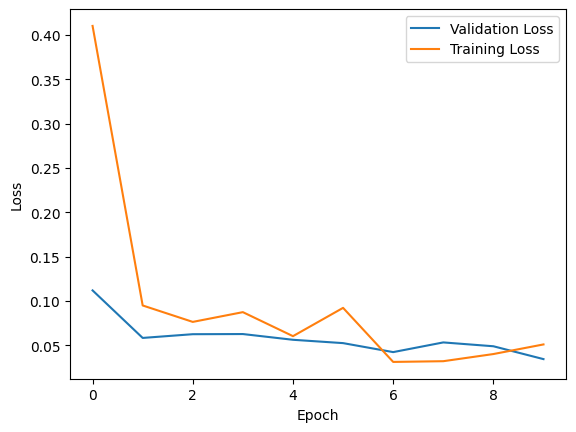

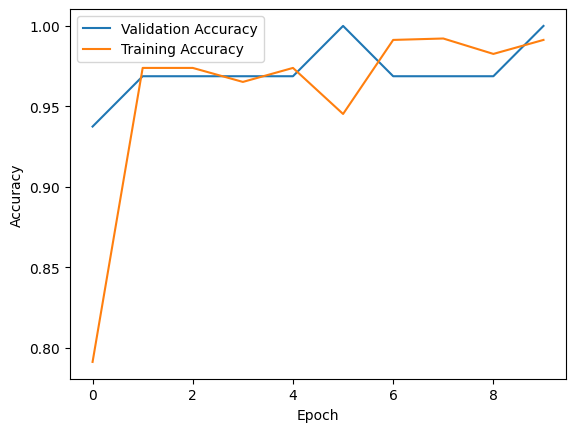

In [ ]:
import matplotlib.pyplot as plt

# Get the training history
history = model.history.history

# Plot the loss
plt.plot(history['val_loss'], label='Validation Loss')
plt.plot(history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.plot(history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# evaluate and predict

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

# Make predictions on a sample of images in the test set
sample_images, sample_labels = next(test_generator)
predictions = model.predict(sample_images)


2/2 [==============================] - 31s 6s/step - loss: 0.0312 - accuracy: 1.0000
Test loss: 0.031206298619508743
Test accuracy: 1.0
1/1 [==============================] - 23s 23s/step


## no of images in test set

In [ ]:
test_generator.samples

40

# predictions

2/2 [==============================] - 30s 5s/step - loss: 0.0312 - accuracy: 1.0000
Test loss: 0.03120627999305725
Test accuracy: 1.0
1/1 [==============================] - 22s 22s/step


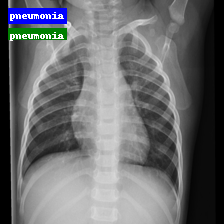

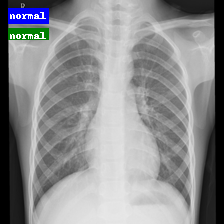

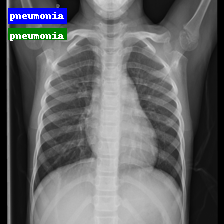

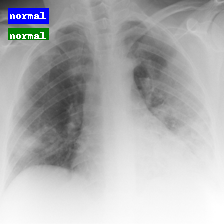

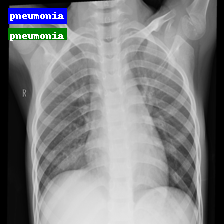

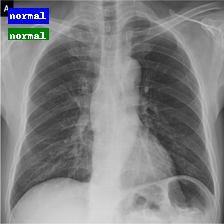

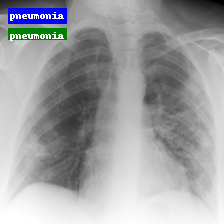

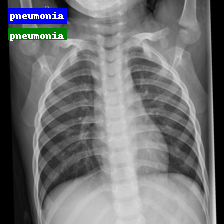

In [ ]:
from PIL import Image, ImageDraw

test_loss, test_acc = model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

# Make predictions on a sample of images in the test set
sample_images, sample_labels = next(test_generator)
y_pred = model.predict(sample_images)

# Display 8 random images from the test set and show true and predicted labels
num_samples = 8
indices = np.random.choice(range(sample_images.shape[0]), num_samples, replace=False)

for i in indices:
    # Get image path and true label
    image_path = test_generator.filepaths[i]
    true_label = 'pneumonia' if sample_labels[i] == 1 else 'normal'

    # Make prediction and get predicted label
    pred_prob = y_pred[i]
    pred_label = 'pneumonia' if pred_prob > 0.5 else 'normal'

    # Set color based on true and predicted labels
    true_color = 'blue'
    pred_color = 'green' if pred_label == true_label else 'red'

    # Load image and resize it
    image = Image.open(image_path)
    image = image.resize((224, 224))

    # Create a new blank image with same size as original image
    text_image = Image.new('RGBA', image.size, (255, 255, 255, 0))

    # Draw true label in blue
    draw = ImageDraw.Draw(text_image)
    text_size = draw.textsize(true_label)
    text_position = (10, 10)
    rect_position = (8, 8, 12 + text_size[0], 12 + text_size[1])
    draw.rectangle(rect_position, fill=true_color)
    draw.text(text_position, true_label, fill='white')

    # Draw predicted label in green or red
    draw = ImageDraw.Draw(text_image)
    text_size = draw.textsize(pred_label)
    text_position = (10, 30)
    rect_position = (8, 28, 12 + text_size[0], 28 + text_size[1])
    draw.rectangle(rect_position, fill=pred_color)
    draw.text(text_position, pred_label, fill='white')

    # Blend the original image with the new image containing labels
    blended_image = Image.alpha_composite(image.convert('RGBA'), text_image)

    # Show the blended image
    blended_image.show(title=f'True: {true_label}, Predicted: {pred_label}', command='fim')


In [ ]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
class_names=['NORMAL','PNEUMONIA']

## CONFUSION MATRIX

2/2 [==============================] - 31s 4s/step - loss: 0.0312 - accuracy: 1.0000
Test loss: 0.03120627999305725
Test accuracy: 1.0
1/1 [==============================] - 20s 20s/step


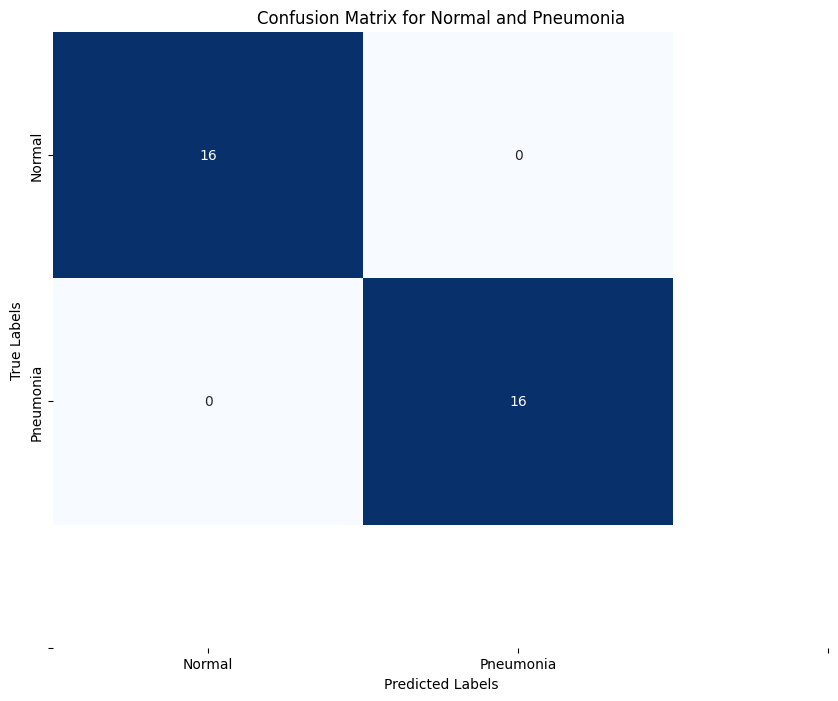

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

# Make predictions on a sample of images in the test set
sample_images, sample_labels = next(test_generator)
predictions = model.predict(sample_images)

# Get the true labels
true_labels = [np.argmax(label) for label in sample_labels]

# Get the predicted labels
predicted_labels = [np.argmax(pred) for pred in predictions]

# Generate confusion matrix for Normal
normal_cm = confusion_matrix(true_labels[:len(sample_images)//2], predicted_labels[:len(sample_images)//2])

# Generate confusion matrix for Pneumonia
pneumonia_cm = confusion_matrix(true_labels[len(sample_images)//2:], predicted_labels[len(sample_images)//2:])

# Combine the two confusion matrices
combined_cm = np.vstack((np.hstack((normal_cm, np.zeros_like(normal_cm))), np.hstack((np.zeros_like(pneumonia_cm), pneumonia_cm))))

# Set up the figure
plt.figure(figsize=(10, 8))
sns.heatmap(combined_cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0.5,1.5,2.5], ['Normal', 'Pneumonia', ''])
plt.yticks([0.5,1.5,2.5], ['Normal', 'Pneumonia', ''])
plt.title('Confusion Matrix for Normal and Pneumonia')

plt.show()



# f1 precison recall

In [ ]:
from sklearn.metrics import classification_report

# Predict on test set
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred)

# Get true labels
y_true = test_generator.classes

# Print classification report
class_names = list(train_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_names)

print(report)


2/2 [==============================] - 42s 4s/step
              precision    recall  f1-score   support

      NORMAL       0.50      0.50      0.50        20
   PNEUMONIA       0.50      0.50      0.50        20

    accuracy                           0.50        40
   macro avg       0.50      0.50      0.50        40
weighted avg       0.50      0.50      0.50        40



# precision recall curve

2/2 [==============================] - 28s 4s/step


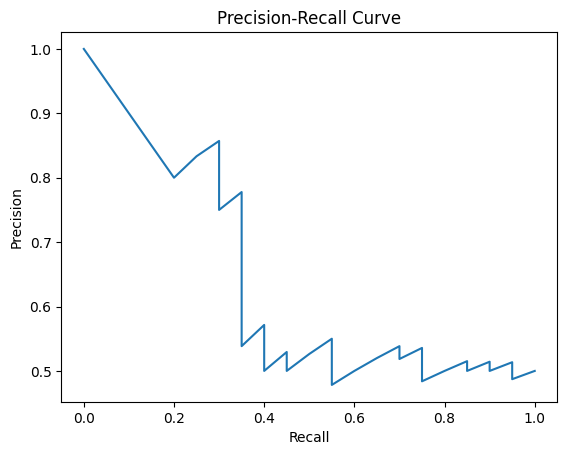

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Predict on test set
y_pred = model.predict(test_generator)

# Get true labels
y_true = test_generator.classes

# Calculate precision-recall curve and plot it
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.show()
